<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Titanic/blob/Model-tuning/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Packages & Functions**


In [453]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import shapiro

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC 

from sklearn.model_selection import cross_val_score

In [454]:
def nan_percentage(df, colname):
  return (df[colname].isnull().sum() / df.shape[0]) * 100

def standardize_col(df, cols):
  for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

def remove_outliers(df, col):
  Q1 = np.quantile(df[col], 0.25)
  Q3 = np.quantile(df[col], 0.75)
  IQR = Q3 - Q1

  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  print(f'lower = {lower}, upper = {upper}, IQR = {IQR}')

  # after filtering, keep only data within [lower, upper]
  filtered_vals = [x for x in df[col] if (x > lower) & (x < upper)]
  return df.loc[df[col].isin(filtered_vals)]

def nan_statistics(df):
  nan_cols = df.loc[:, df.isnull().any()].columns
  for col in nan_cols:
    print(f'Column {col} has {nan_percentage(df, col):.2f} % of Nans')
  print(df.isna().sum())

def nans_remain(df):
  return df.isnull().values.any()

#**1. Concatenate train & test**

In [455]:
# Setting file download from google Drive

drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/1.Titanic/'

train_path = gdrive_path + df_path + "train.csv"
test_path =  gdrive_path + df_path + "test.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [456]:
train = pd.read_csv(train_path, index_col='PassengerId')
test = pd.read_csv(test_path, index_col='PassengerId')
df_whole = pd.concat([train, test], sort=True)

#**2. Feature Exploration ('Cabin', 'Parch')**

In [457]:
# Step 1. General Summary
df_whole.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1046 non-null   float64
 1   Cabin     295 non-null    object 
 2   Embarked  1307 non-null   object 
 3   Fare      1308 non-null   float64
 4   Name      1309 non-null   object 
 5   Parch     1309 non-null   int64  
 6   Pclass    1309 non-null   int64  
 7   Sex       1309 non-null   object 
 8   SibSp     1309 non-null   int64  
 9   Survived  891 non-null    float64
 10  Ticket    1309 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [458]:
nan_statistics(df_whole)

Column Age has 20.09 % of Nans
Column Cabin has 77.46 % of Nans
Column Embarked has 0.15 % of Nans
Column Fare has 0.08 % of Nans
Column Survived has 31.93 % of Nans
Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
dtype: int64


In [459]:
# Age -> substitute with average / median
# Embarked -> substitute column (depends on significancy)
# Name, Ticket -> can drop the column

# 'Embarked' feature has two Nans -> Mrs.George Nelson & Amelie Icard
# embarked in Southampton -> substitute with S

df_whole['Embarked'] = df_whole['Embarked'].fillna('S')
Cabins = df_whole.loc[:, 'Cabin']
Cabins.fillna('M', inplace=True)

# Leave only names of the Cabin sections
Cabins = Cabins.str.slice(0, 1)
Cabins.value_counts()
df_whole['Cabin'] = Cabins.values

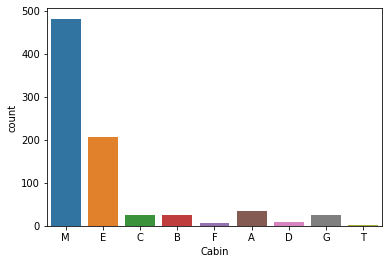

In [460]:
survived = df_whole[df_whole['Survived'] == 1]
died = df_whole[df_whole['Survived'] == 0]
sns.countplot(x = 'Cabin', data=survived)
sns.countplot(x='Cabin', data=died)

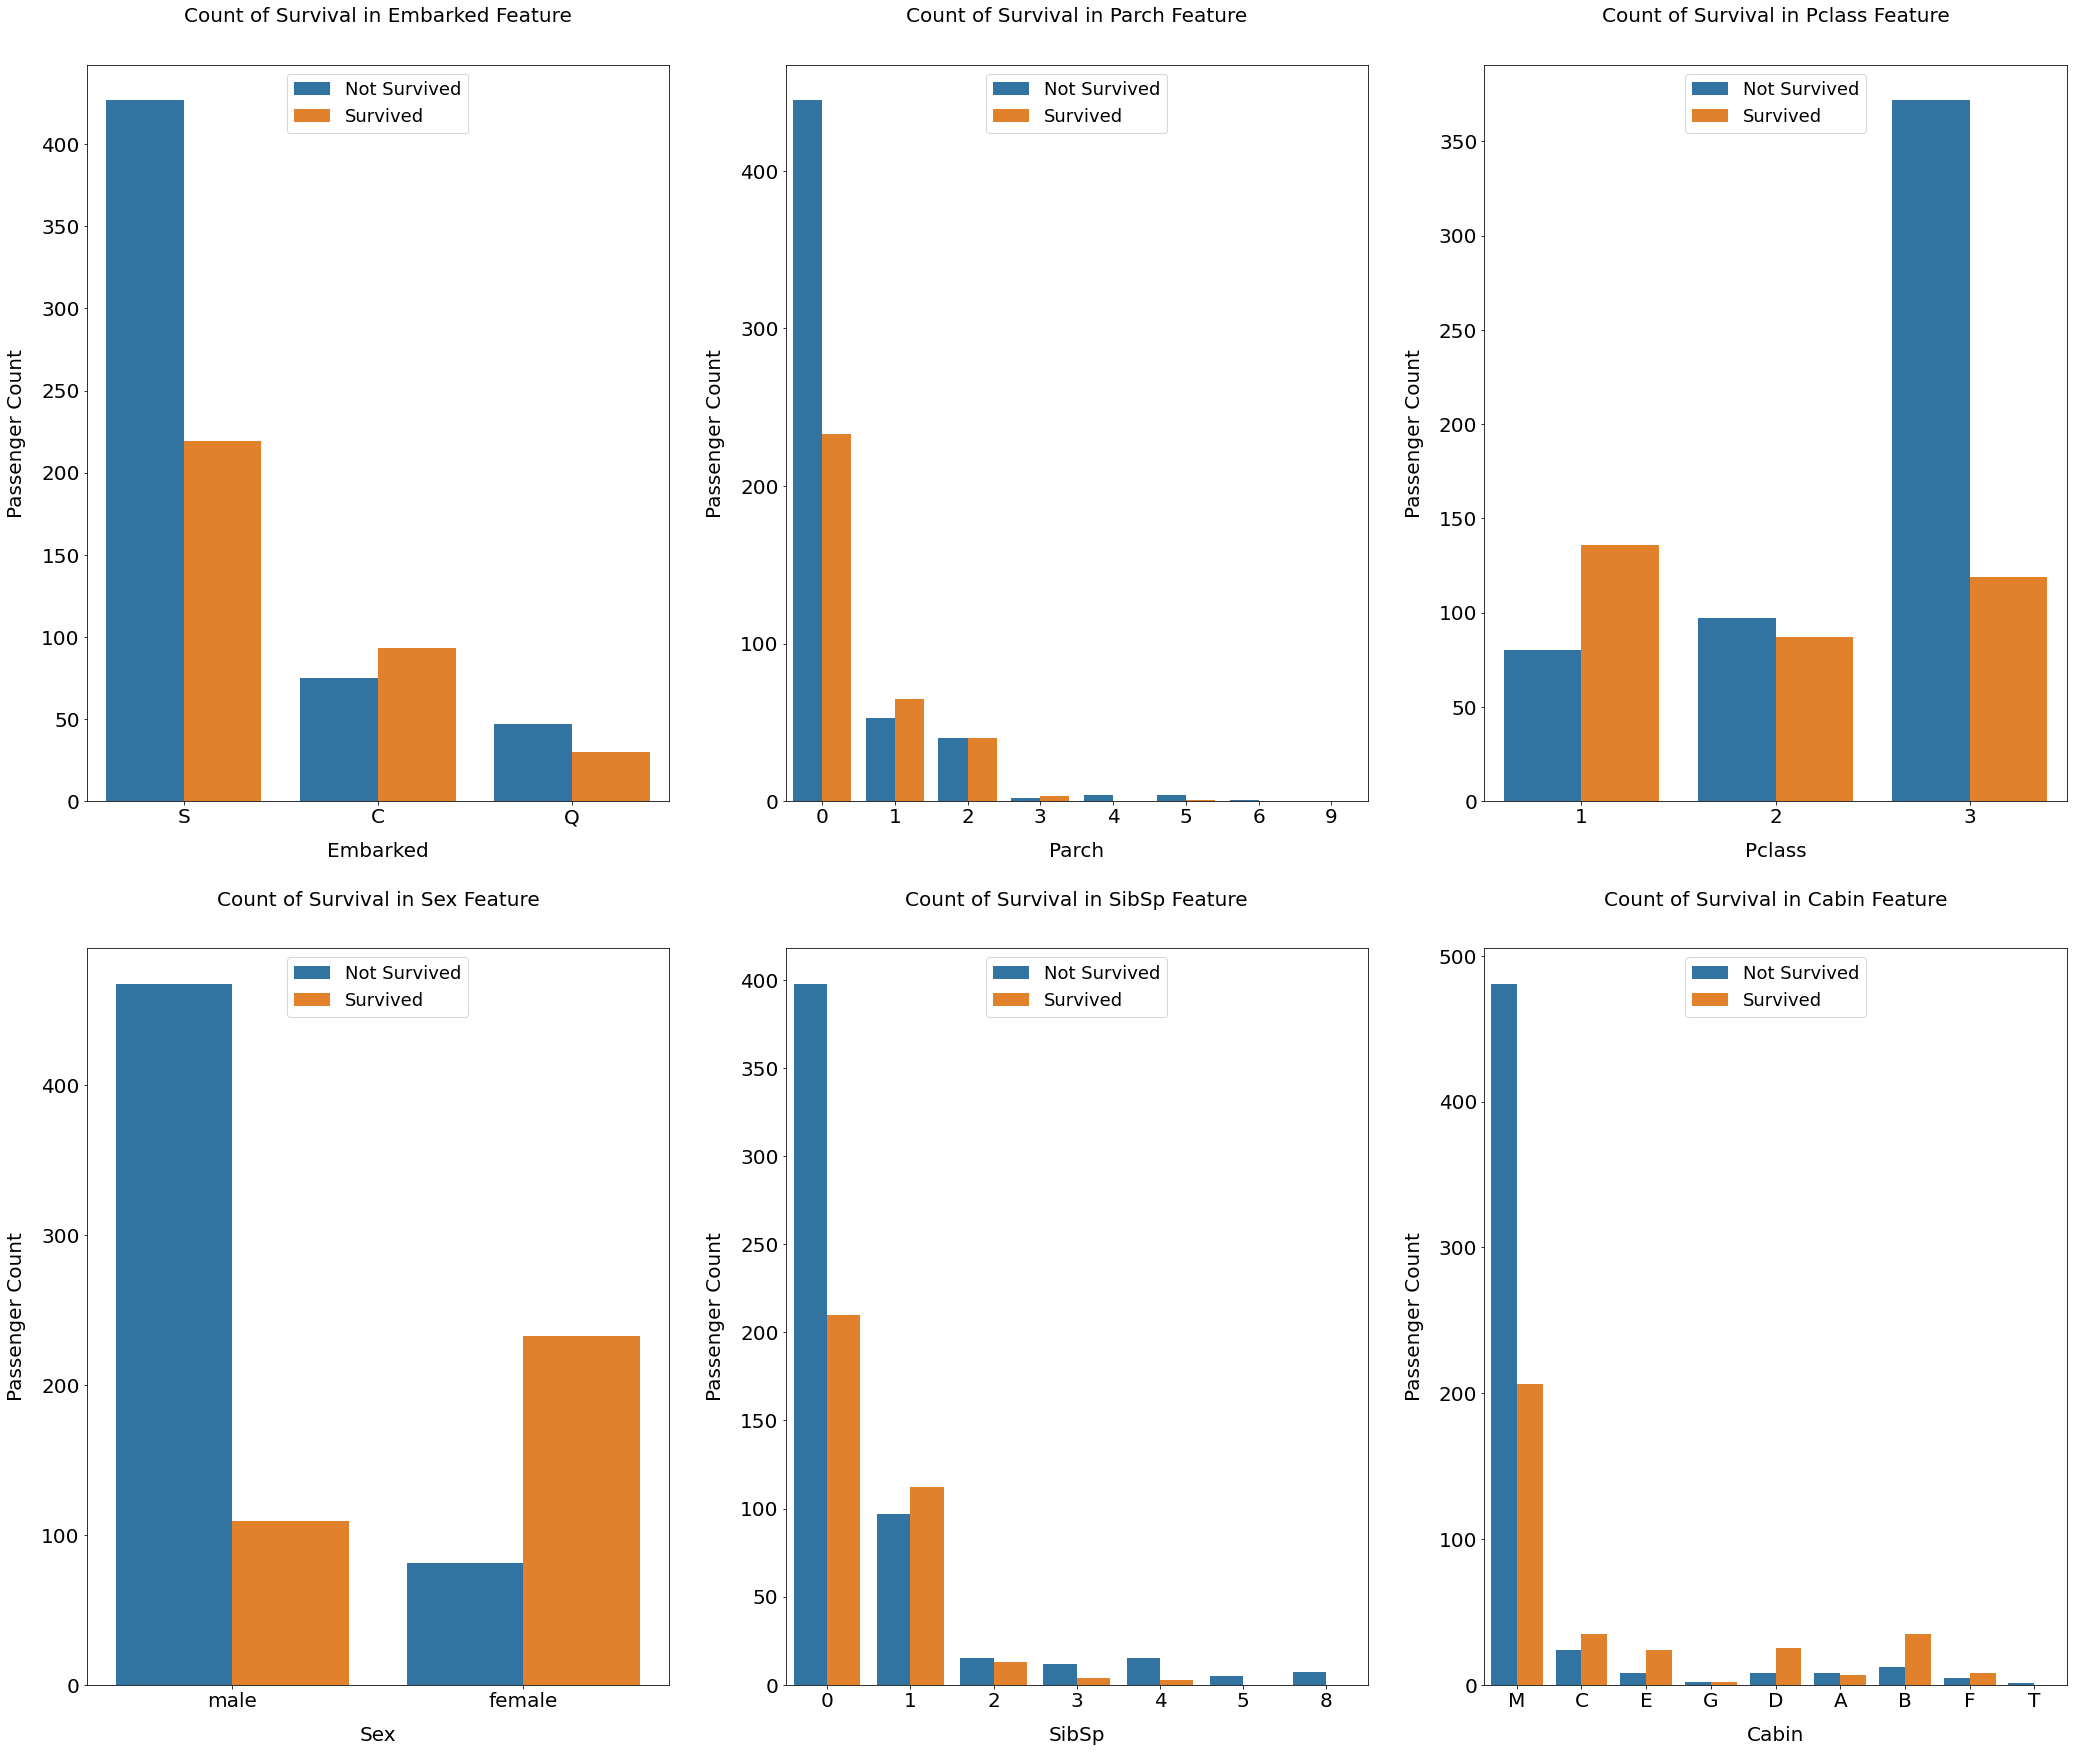

In [461]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Cabin']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_whole)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

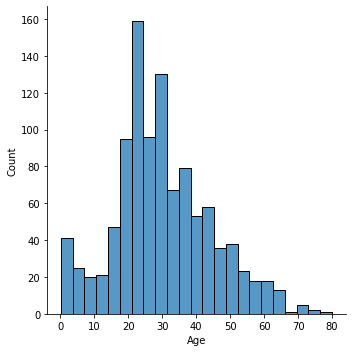

In [462]:
# Shapiro-Wilk test indicates, that 'Age' feature
# is from normal distr`ibution -> we will use z-standartization
# for this feature
sns.displot(df_whole, x='Age')

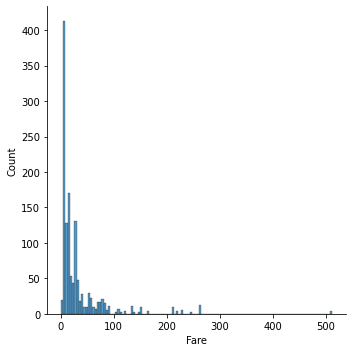

In [463]:
sns.displot(df_whole, x='Fare')

#**3. Feature generation conclusions**
1. We can regroup the SibSp & Parch feature on low, medium, high
2. Regroup Cabin column on BD, GFT, AE, C, M
3. Remove 'Ticket' and 'Name' Column
4. Standard-scale the 'age' column
5. Add Family size feature
6. Add Title feature


In [464]:
# Replace Cabin feature
df_whole['Cabin'].replace(['B', 'D'], 'BD', inplace=True)
df_whole['Cabin'].replace(['F', 'G', 'T'], 'FGT', inplace=True)
df_whole['Cabin'].replace(['A', 'E'], 'AE', inplace=True)

In [465]:
# Add Family Size feature
df_whole['FamilySize'] = df_whole['SibSp'] + df_whole['Parch'] + 1

# Small, Big family feature
df_whole['SmallFamily'] = df_whole['FamilySize'].map(lambda size: 1 if 2 <= size < 4 else 0)
df_whole['BigFamily'] = df_whole['FamilySize'].map(lambda size: 1 if size >= 4 else 0)

# Replace Family feature
df_whole['SibSp'].replace([0, 1], 'high', inplace=True)
df_whole['SibSp'].replace([2, 3, 4, 5, 6, 8], 'low', inplace=True)

df_whole['Parch'].replace([0], 'low', inplace=True)
df_whole['Parch'].replace([1, 2], 'middle', inplace=True)
df_whole['Parch'].replace([3, 4, 5, 6, 9], 'high', inplace=True)

# Title feature
titles_dict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Mme": "Mrs",
    "Mlle": 'Miss',
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
}

df_whole['Title'] = df_whole['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
df_whole['Title'] = df_whole['Title'].map(titles_dict)
df_whole['Title'].fillna('Mr', inplace=True)


In [466]:
# Drop Ticket and Name columns
df_whole.drop(columns=['Ticket', 'Name'], inplace=True, axis=0)

# **4. Splitting whole dataset (Train, Validation, Test)**

In [467]:
df_train = df_whole.loc[1:891]
df_test = df_whole.loc[892:]
df_test.drop(columns = ['Survived'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [468]:

X = df_train.drop('Survived', axis=1)
Y = df_train['Survived']

seed = 42
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=seed,
                                                    stratify=Y,
                                                    shuffle=True)

# **5. Preprocessing Pipeline & Model Selection**

In [473]:
str_cat_features = ['Cabin', 'Embarked', 'Parch', 'Sex', 'SibSp', 'Title']
str_cat_transformers = Pipeline(
    steps = [
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

int_cat_features = ['Pclass', 'FamilySize', 'SmallFamily', 'BigFamily']
int_cat_transformers = Pipeline(
    steps = [
             ('imputer', SimpleImputer(strategy='most_frequent'))
    ]
)

num_features = ['Age', 'Fare']
num_transformers = Pipeline(
    steps = [
             ('imputer', SimpleImputer()),
             ('scaler', StandardScaler())
    ]
)

In [474]:
def build_pipe(model):
  preprocess = ColumnTransformer(
      transformers = [
                      ('int_cat', int_cat_transformers, int_cat_features),
                      ('str_cat', str_cat_transformers, str_cat_features),
                      ('num', num_transformers, num_features)
      ]
  )

  pipe = Pipeline(
      steps = [
               ('preprocessing', preprocess),
               ('modeling', model)
      ]
  )
  return pipe

In [475]:
models = [
          ('RandomForest', RandomForestClassifier()),
          ('LogRegression', LogisticRegression()),
          ('SVC', SVC())
]

for name, model in models:
  model_pipeline = build_pipe(model)
  cv_scores = cross_val_score(model_pipeline, X_train, Y_train)
  print(cv_scores.mean())

0.7993105486063232
0.8090515118684133
0.8230769230769232


# **6. Model Fine-Tuning & Final Model Selection**

In [478]:
models = [
          ('RandomForest',             
           RandomForestClassifier(),
            {
               'modeling__n_estimators': [500, 600],
               'modeling__max_depth': [20, 25],
               'modeling__min_samples_leaf': [2, 1],
               'modeling__random_state': [42],
               'modeling__max_samples': [0.6, 0.9]
            }),
          (
            'LogRegression',
            LogisticRegression(),
           {
               'modeling__C': [1, 5, 10]
           } 
          ),
          (
            'SVC',
            SVC(),
           {
               'modeling__C': [1, 5, 10]
           }
          )
]

fine_tuning_res = {}
for name, model, param_grid in models:
  pipe = build_pipe(model)
  gs = GridSearchCV(pipe, param_grid)
  gs.fit(X_train, Y_train)
  print(f'Model: {name}, bestscore: {gs.best_score_}')
  fine_tuning_res[name] = gs

Model: RandomForest, bestscore: 0.8301388752092977


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model: LogRegression, bestscore: 0.8090515118684133
Model: SVC, bestscore: 0.8230769230769232


In [479]:
final_model = fine_tuning_res['RandomForest'].best_estimator_
final_model.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('int_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                                 

In [487]:
fine_tuning_res['RandomForest'].best_score_

0.8301388752092977

In [491]:
# Print Feature importances
for name, score in sorted(
    zip(X_train.columns, 
        final_model[1].feature_importances_), 
        key=lambda x: -x[1]):
  print(name, score)

Age 0.07167520865884303
FamilySize 0.048652777167594106
Cabin 0.045147346283792904
Embarked 0.016246504940225157
Title 0.014878326997632087
SmallFamily 0.01143525344385139
Pclass 0.00964453676370937
Fare 0.009429152533292707
Parch 0.008216165656911708
BigFamily 0.007080134411025523
Sex 0.005989875553412591
SibSp 0.0017701332016050084


# **6. Validation Results**

In [483]:
validation_res = final_model.predict(X_val)
print(confusion_matrix(Y_val, validation_res))
print(classification_report(Y_val, validation_res))

[[97 13]
 [22 47]]
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       110
         1.0       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [484]:
validation_accuracy = accuracy_score(Y_val, validation_res)
validation_accuracy

0.8044692737430168

# **7. Results submission**

In [485]:
pred = final_model.predict(df_test).astype('int')

In [486]:
# Saving the submission data to csv file
submission = pd.DataFrame({
    'PassengerId': df_test.index,
    'Survived': pred
})
submission.to_csv(gdrive_path + df_path + "submission.csv", index=False)